In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
%matplotlib qt
%matplotlib inline

## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


### Compute the camera calibration using chessboard images

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

### Apply a distortion correction to raw images.

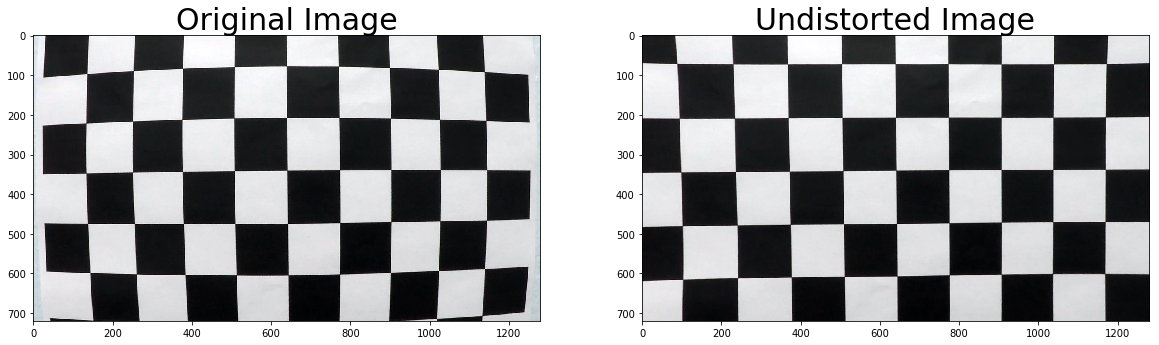

In [3]:
# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('./camera_cal/calibration_test.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig('./output_images/undistort_output.jpg')

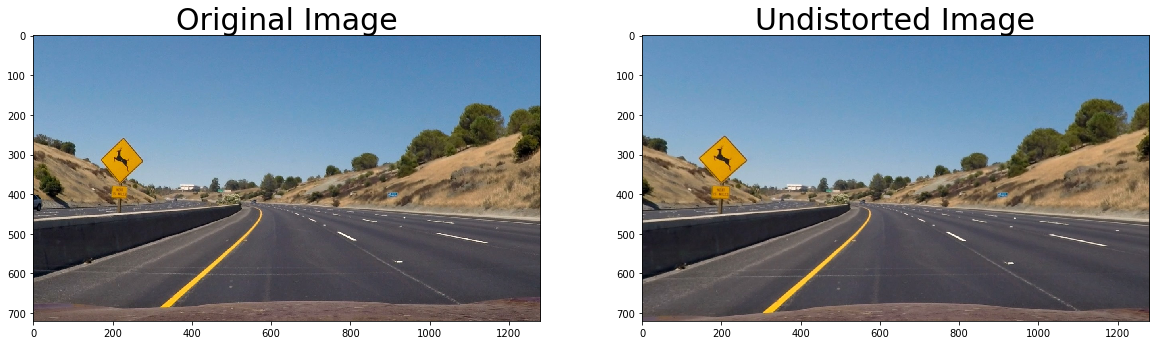

In [4]:
image=mpimg.imread('./test_images/test2.jpg')
dst = cv2.undistort(image, mtx, dist, None, mtx)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig('./output_images/undistort_output_2.jpg')

### Use color transforms, gradients, etc., to create a thresholded binary image.

In [5]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='y', thresh=(150, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

In [6]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=13, mag_thresh=(100, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [7]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=13, thresh=(0.8,1.3)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [8]:
# Apply each of the thresholding functions
def combine_sobel(image,ksize=13):
    gradx = abs_sobel_thresh(image, orient='x',  thresh=(100, 255))
    grady = abs_sobel_thresh(image, orient='y',  thresh=(100, 255))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(100, 255))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.1))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

In [9]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(150, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

In [10]:
def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [11]:
def edge_detection(image,kernel_size=13):
    #apply Gaussian smoothing
    cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    hls_binary = hls_select(image)
    sxbinary = combine_sobel(image)
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, hls_binary))
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(sxbinary == 1) | (hls_binary == 1)] = 1
    #filter by region of interest
    imshape=image.shape#410
    vertices = np.array([[(170,imshape[0]),(550, 460), (700, 460), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges= region_of_interest(combined_binary, vertices)
    return masked_edges

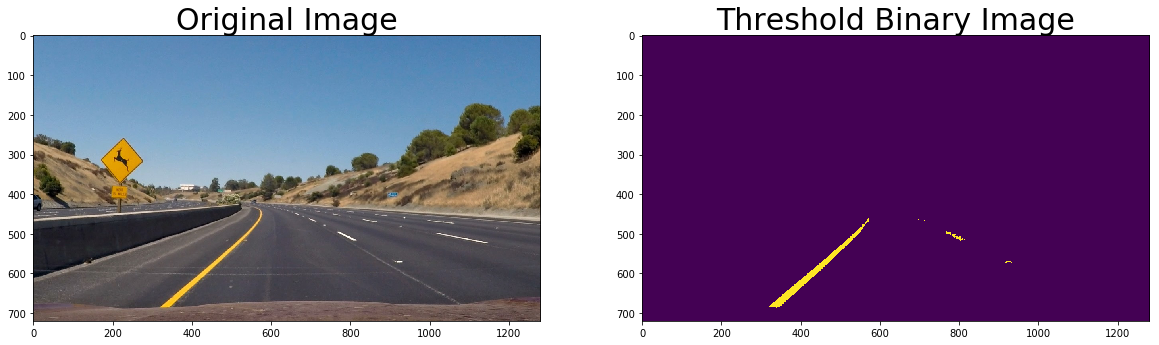

In [12]:
image=mpimg.imread('./test_images/test2.jpg')
edge_image=edge_detection(image)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(edge_image)
ax2.set_title('Threshold Binary Image', fontsize=30)
plt.savefig('./output_images/threshold_binary.jpg')

### Apply a perspective transform to rectify binary image ("birds-eye view")

In [13]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    offset = 100 # offset for dst points
    # Grab the image shape
    img_size = (undist.shape[1], undist.shape[0])
    # For source points
    src = np.float32([
                      [585, 460], 
                      [203, 720], 
                      [1127, 720],
                      [695, 460]])
    # For destination points
    dst = np.float32([
                      [320, 0], 
                      [320, 720], 
                      [960, 720],
                      [960, 0]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M, Minv

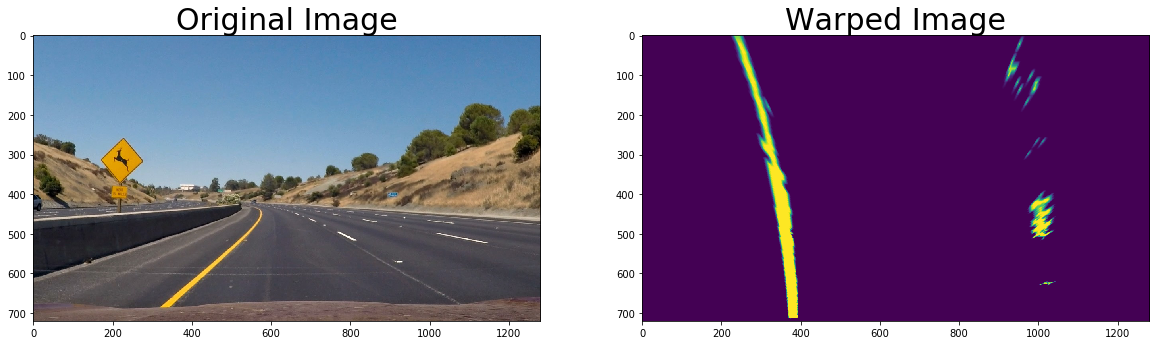

In [14]:
image=mpimg.imread('./test_images/test2.jpg')
top_down, perspective_M,Minv =corners_unwarp(edge_detection(image), mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(top_down)
ax2.set_title('Warped Image', fontsize=30)
plt.savefig('./output_images/warp.jpg')

### Detect lane pixels and fit to find the lane boundary.

In [15]:
def fit_lane(nonzerox,nonzeroy,left_lane_inds,right_lane_inds,binary_warped):
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return leftx,lefty,rightx,righty,left_fit,right_fit,left_fitx,right_fitx,ploty

In [16]:
def blind_search(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    leftx,lefty,rightx,righty,left_fit,right_fit,left_fitx,right_fitx,ploty = fit_lane(nonzerox,nonzeroy,left_lane_inds,right_lane_inds,binary_warped)
    return leftx,lefty,rightx,righty,left_fit,right_fit,left_fitx,right_fitx,ploty,left_lane_inds,right_lane_inds

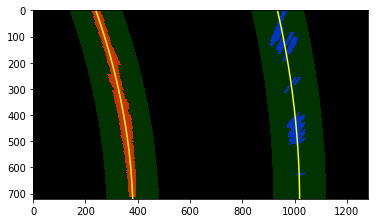

In [17]:
#visualization example 
leftx,lefty,rightx,righty,left_fit,right_fit,left_fitx,right_fitx,ploty,left_lane_inds,right_lane_inds=blind_search(top_down)
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((top_down, top_down, top_down))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
nonzero = top_down.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()

margin=100
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img,200, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('./output_images/fit_line.jpg')

In [18]:
def find_next_lane(binary_warped,left_fit,right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    leftx,lefty,rightx,righty,left_fit,right_fit,left_fitx,right_fitx,ploty=fit_lane(nonzerox,nonzeroy,left_lane_inds,right_lane_inds,binary_warped)
    return leftx,lefty,rightx,righty,left_fitx,right_fitx,ploty

In [19]:
# Evaluates polynomial and finds value at given point
def get_x_for_line(line_fit, line_y):
    poly = np.poly1d(line_fit)
    return poly(line_y)

# calculate the distance form center
def compute_dist_center(left_fit,right_fit,image):
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    image_height = image.shape[0]
    image_width = image.shape[1]
    
    # Calculate bottom point for each lane
    left_fitx_bottom_m = get_x_for_line(left_fit, image_height)
    right_fitx_bottom_m = get_x_for_line(right_fit, image_height)
    
    # Calculate image center, in meters
    center_ideal_m = image_width * xm_per_pix / 2
    # Calculate actual center of the lane, in meters
    center_actual_m = np.mean([left_fitx_bottom_m, right_fitx_bottom_m])* xm_per_pix
    # Calculate distance from center, in meters
    distance_from_center = abs(center_ideal_m - center_actual_m)
    return distance_from_center

def compute_curverad(yvals,xvals):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(yvals)
    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(yvals*ym_per_pix, xvals*xm_per_pix, 2)
    # Calculate the new radii of curvature
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    # Now our radius of curvature is in meters
    return curverad

In [20]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    #Checking that they are roughly parallel - to do 
    
    def sanity_check_curve(self,R):
        #Checking that they have similar curvature
        R0 = self.radius_of_curvature
        curverad_diff = abs(R-R0)/R0
        #if difference pass threshold, return false 
        return (curverad_diff <= 0.5)  

In [21]:
def detect_lane(binary_warped):
    count_fail=0
    if left_lane.detected==False and right_lane.detected==False: #calculate from scratch 
        
        leftx,lefty,rightx,righty,left_fit,right_fit,left_fitx,right_fitx,ploty,left_lane_inds,right_lane_inds = blind_search(binary_warped)
        
        left_lane.current_fit=left_fit
        right_lane.current_fit=right_fit
        
        left_lane.allx=leftx
        left_lane.ally=lefty
        right_lane.allx=rightx
        right_lane.ally=righty
        
        left_R=compute_curverad(lefty,leftx)
        right_R=compute_curverad(righty,rightx)
        
        left_lane.radius_of_curvature=left_R
        right_lane.radius_of_curvature=right_R

        lane_dist=right_fitx-left_fitx
        
        left_lane.detected=True
        right_lane.detected=True 
        
        count_fail = 0

    else:
        left_fit=left_lane.current_fit
        right_fit=right_lane.current_fit
        
        leftx,lefty,rightx,righty,left_fitx,right_fitx,ploty = find_next_lane(binary_warped,left_fit,right_fit)
        
        D=right_fitx-left_fitx  #lane distance
        
        left_R=compute_curverad(lefty,leftx)
        right_R=compute_curverad(righty,rightx)
        
        if left_lane.sanity_check_curve(left_R)==False or right_lane.sanity_check_curve(right_R)==False:
        # if does not pass curvature radius sanity check:
            count_fail+=1
            if count_fail<5:
            #if less than n times:
                left_lane.detected=True
                right_lane.detected=True
                pass #retain previous position, continue to next frame 
            if count_fail>=5:
            #if more than n times:
                left_lane.detected=False
                right_lane.detected=False
                pass #start from scratch 
        else:
            count_fail=0
            #update the characteristics 
            left_lane.current_fit=left_fit
            right_lane.current_fit=right_fit

            left_lane.allx=leftx
            left_lane.ally=lefty
            right_lane.allx=rightx
            right_lane.ally=righty


            left_lane.radius_of_curvature=left_R
            right_lane.radius_of_curvature=right_R
         
            left_lane.detected=True
            right_lane.detected=True
    
    dist_center = compute_dist_center(left_lane.current_fit,right_lane.current_fit,binary_warped)
    avg_curverad = (left_lane.radius_of_curvature+right_lane.radius_of_curvature)/2
    return left_fitx,right_fitx,ploty,avg_curverad,dist_center

### Warp the detected lane boundaries back onto the original image.

In [22]:
# Create an image to draw the lines on
def draw_poly(image,warped,left_fitx,right_fitx,ploty,Minv,curverad=0,dist_center=0):
    
    image_height = image.shape[0]

    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    stats_text = 'Curvature: {0:.0f}m, Center offset: {1:.1f}m'.format(curverad, \
                                                                dist_center)
    text_offset = 50
    text_shift = 1
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    cv2.putText(result, stats_text, \
                (text_offset + text_shift, image_height - text_offset + text_shift), \
                font, 1, (0, 0, 0), 2, cv2.LINE_AA)
    plt.imshow(result)
    
    return result

In [23]:
def process_image(image):
    # Apply pipeline to the image to create black and white image
    img = edge_detection(image)
    # Warp the image to make lanes parallel to each other
    warped, M, Minv = corners_unwarp(img, mtx, dist)
    # Find the lines fitting to left and right lanes
    left_fitx,right_fitx,ploty,curverad,dist_center = detect_lane(warped)
    # Return the original image with colored region
    return draw_poly(image,warped,left_fitx,right_fitx,ploty,Minv,curverad,dist_center)

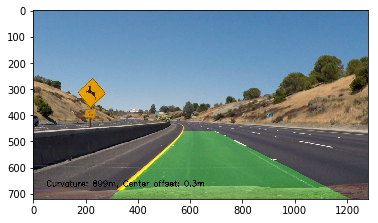

In [24]:
left_lane = Line()
right_lane = Line()
image=mpimg.imread('./test_images/test2.jpg')
output=process_image(image)
plt.imshow(output)
plt.savefig('./output_images/output.jpg')

### Test on Videos

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
left_lane = Line()
right_lane = Line()
output = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(output, audio=False)